<a href="https://colab.research.google.com/github/maciejskorski/beta_tails/blob/main/Beta_SubGamma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Berstein Bounds for Beta Distribution

In [1]:
#@title Install Packages

## Optimality

Let $X\sim\mathsf{Beta}(\alpha,\beta)$. We prove that the *best Chernoff-Cramer  bound* is
$$
\mathbf{P}\{X>\mathbf{E}[X]+\epsilon\} \leqslant \exp\left(-\frac{\epsilon^{2}}{2 v} + \frac{c \epsilon^{3}}{6 v^{2}} + O\left(\epsilon^{4}\right)\right), \quad \epsilon \to 0.
$$
which matches the bound in the paper.

In [2]:
import sympy as sm
from IPython.display import display

t,eps,v,c = sm.symbols('t,epsilon,v,c')

MGF = 1 + t**2*v/2 + t**3*v*c/6 
log_MGF = sm.log(MGF)
d_log_MGF = log_MGF.diff(t)
crammer_chernoff = eps*t-log_MGF

ks = [1,2]
t_eps_coeffs = [ 1/sm.factorial(k)*((t/d_log_MGF)**k).diff(t,k-1).series(t,0,1).subs({t:0}) for k in ks]
t_eps = sum( eps**k*c.simplify() for (c,k) in zip(t_eps_coeffs,ks) )
t_eps = t_eps.series(eps,0,3)
display(sm.Eq(sm.symbols('t_eps'),t_eps))

bound_best = crammer_chernoff\
  .subs({t:t_eps})\
  .series(eps,0,4)

display(sm.Eq(sm.symbols('\psi^{*}(\epsilon)'),bound_best))

Eq(t_eps, -c*epsilon**2/(2*v**2) + epsilon/v)

Eq(\psi^{*}(\epsilon), epsilon**2/(2*v) - c*epsilon**3/(6*v**2) + O(epsilon**4))

## Moment Recursion

The code below efficiently implements the order-2 recursion for central moments of beta distribution. 

In [3]:
from functools import lru_cache

@lru_cache(100)
def beta_central_moment(d,a,b):
  """ Find the central moment of order d for Beta(a,b) """
  if d == 0:
    return 1
  elif d == 1:
    return 0
  else:
    # recurssion coefficients derived in the paper
    c1 = (d-1)*(b-a)/((a+b)*(a+b+d-1))
    c2 = (d-1)*a*b/((a+b)**2*(a+b+d-1))
    return c1*beta_central_moment(d-1,a,b)+c2*beta_central_moment(d-2,a,b)

In [4]:
# example: find the variance
import sympy as sm
b,a = sm.symbols('beta alpha',positive=True)
beta_central_moment(2,a,b)

alpha*beta/((alpha + beta)**2*(alpha + beta + 1))

In [5]:
# example: find the skewness
import sympy as sm
b,a = sm.symbols('beta alpha',positive=True)
var = beta_central_moment(2,a,b)
(beta_central_moment(3,a,b)/sm.sqrt(var**3)).factor()

-2*(alpha - beta)*sqrt(alpha + beta + 1)/(sqrt(alpha)*sqrt(beta)*(alpha + beta + 2))

## Numerical Comparison

The sub-gamma bounds from this paper are demonstrated better than sub-gaussian bounds, for skewed distributions. For sub-gaussian bounds we use [the author implementation ](https://github.com/jarbel/Beta-sub-Gaussian/blob/master/functions/subGaussian-fun.R) with adjusted initial conditions for the root-finding part. 

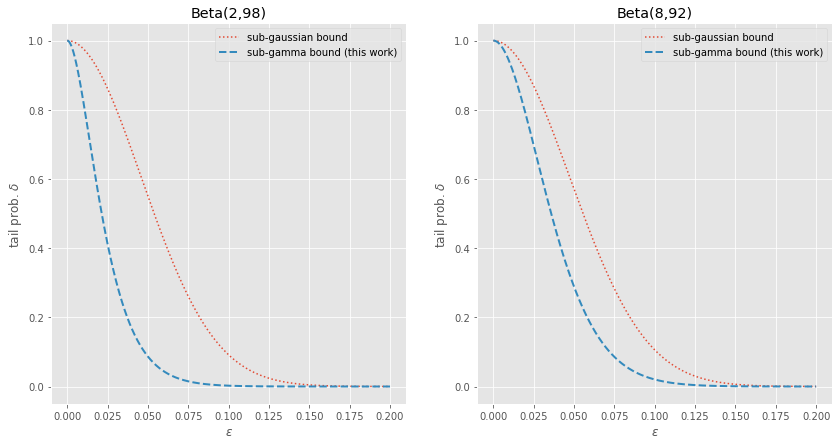

In [6]:
from mpmath import hyp1f1
from scipy.optimize import root_scalar
from scipy.stats import beta
from scipy.special import betainc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')


hyp1f1 = np.vectorize(hyp1f1,otypes=(np.double,))

def beta_subgauss(a,b):
  ''' variance for sub-gaussian approx of beta distribution
      based on https://arxiv.org/pdf/1705.00048.pdf and implementation https://github.com/jarbel/Beta-sub-Gaussian/blob/master/functions/subGaussian-fun.R '''
  f = lambda x: np.log(hyp1f1(a,a+b,x)) - 0.5*x*a*1/(a+b)*( 1 + hyp1f1(a+1,a+b+1,x) / hyp1f1(a,a+b,x) )
  x0 = root_scalar(f,bracket=[1e-3,5e2],method='bisect').root
  v2 = a*1/((a+b)*x0)*(hyp1f1(a+1,a+b+1,x0) / hyp1f1(a,a+b,x0)-1)
  return v2

def beta_variance(a,b):
  return a*b * 1/ (a+b)**2 * 1/(a+b+1)

def beta_subgamma(a,b):
  ''' variance and scale for sub-gamma approx of beta distribution 
      based on: (this paper)'''
  v2 = beta_variance(a,b)
  c = max(2/3*(b-a)/(a+b)*1/(a+b+1),0)
  return v2,c

def beta_tail_frankl(a,b,eps):
  ''' the sub-gamma tail approximation due to Frankl and Maehera 
      based on discussion in: Continuous Univariate Distributions
  '''
  mu = a/(a+b)
  eps = eps / mu
  eps_exp = eps**2/2-eps**3/3
  tail = 2/(eps_exp/eps) * ((a+b)/(2*np.pi*a*b))**0.5 * np.exp(-a*eps_exp)
  
  return tail



def compare_tails(a,b,eps,ax):
  '''compares sub-gaussian and sub-gamma tail approximations for Beta distribution '''

  mean = a/(a+b)
  v2_gauss = beta_subgauss(a,b)
  v2_gamma,c_gamma = beta_subgamma(a,b)

  tail_true = 1-beta(a,b).cdf(mean+eps)
  tail_sub_gauss = np.exp(- eps**2 / (2*v2_gauss) )
  tail_sub_gamma = np.exp(- eps**2/(2*v2_gamma + 2*eps*c_gamma ))

  ax.plot(eps,tail_sub_gauss,':',label='sub-gaussian bound')
  ax.plot(eps,tail_sub_gamma,'--',linewidth=2,label='sub-gamma bound (this work)')

  ax.legend()
  ax.set_xlabel('$\epsilon$')
  ax.set_ylabel('tail prob. $\delta$')
  ax.set_title(f'Beta({a},{b})')
  return tail_sub_gauss,tail_sub_gamma


params = [(2,98,0.2),(8,92,0.2)] # params of your choice
fig,axs = plt.subplots(1,2,figsize=(14,7))

for (a,b,eps_max),ax in zip(params,axs):
  eps = np.linspace(0,eps_max,1000)
  tail_sub_gauss, tail_sub_gamma = compare_tails(a,b,eps,ax)

  out = pd.DataFrame([eps,tail_sub_gauss,tail_sub_gamma]).T
  out.columns = ['eps','subgauss','subgamma']
  out.to_csv(f'beta_{a}_{b}.csv')

plt.show()